In [ ]:

pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Others
import shutil
import random

In [ ]:
# Download dataset
od.download('https://www.kaggle.com/datasets/faudyanurul/strawberry')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: faudyanurul
Your Kaggle Key: ··········


100%|██████████| 83.5M/83.5M [00:02<00:00, 41.8MB/s]


In [ ]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "strawberry/Strawberry/train",
    label_mode="categorical",
    class_names=['Strawberry___healthy', 'Strawberry___Leaf_scorch'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "strawberry/Strawberry/valid",
    label_mode="categorical",
    class_names=['Strawberry___healthy', 'Strawberry___Leaf_scorch'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 3598 files belonging to 2 classes.
==========================Validation Data====================
Found 900 files belonging to 2 classes.


In [ ]:
# All images will be rescaled by 1./255.and augmented
train_datagen = ImageDataGenerator(rescale = 1.0/256.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("strawberry/Strawberry/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("strawberry/Strawberry/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 3598 images belonging to 2 classes.
Found 900 images belonging to 2 classes.


In [ ]:
# Check GPU
!nvidia-smi

Tue Jun  6 04:03:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    29W /  70W |    389MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:

# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

mobilenetv2_1

In [ ]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Strawberry_MobileNetV2_model1_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [ ]:
# Define DIY Model
MobileNetV2_model = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                           

In [ ]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_1 = MobileNetV2_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
180/180 [==============================] - ETA: 0s - loss: 0.2473 - accuracy: 0.9786
Epoch 1: val_accuracy improved from -inf to 0.97000, saving model to Strawberry_MobileNetV2_model1_Based_Augmented


180/180 [==============================] - 124s 457ms/step - loss: 0.2473 - accuracy: 0.9786 - val_loss: 0.2617 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 2/100
180/180 [==============================] - ETA: 0s - loss: 0.0348 - accuracy: 0.9919
Epoch 2: val_accuracy did not improve from 0.97000
180/180 [==============================] - 53s 292ms/step - loss: 0.0348 - accuracy: 0.9919 - val_loss: 1.6226 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 3/100
180/180 [==============================] - ETA: 0s - loss: 0.0149 - accuracy: 0.9958
Epoch 3: val_accuracy did not improve from 0.97000
180/180 [==============================] - 53s 293ms/step - loss: 0.0149 - accuracy: 0.9958 - val_loss: 2.0562 - val_accuracy: 0.7789 - lr: 0.0010
Epoch 4/100
180/180 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9975
Epoch 4: val_accuracy did not improve from 0.97000
180/180 [==============================] - 54s 300ms/step - loss: 0.0100 - accuracy: 0.9975 - val_loss: 1.8467 - v

180/180 [==============================] - 76s 425ms/step - loss: 0.0070 - accuracy: 0.9983 - val_loss: 0.0012 - val_accuracy: 0.9989 - lr: 0.0010
Epoch 7/100
180/180 [==============================] - ETA: 0s - loss: 0.0171 - accuracy: 0.9967
Epoch 7: val_accuracy did not improve from 0.99889
180/180 [==============================] - 52s 291ms/step - loss: 0.0171 - accuracy: 0.9967 - val_loss: 0.9290 - val_accuracy: 0.5278 - lr: 0.0010
Epoch 8/100
180/180 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9978
Epoch 8: val_accuracy did not improve from 0.99889
180/180 [==============================] - 53s 296ms/step - loss: 0.0088 - accuracy: 0.9978 - val_loss: 0.0129 - val_accuracy: 0.9989 - lr: 0.0010
Epoch 9/100
180/180 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9994
Epoch 9: val_accuracy did not improve from 0.99889
180/180 [==============================] - 52s 291ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.0080 - va

180/180 [==============================] - 78s 437ms/step - loss: 7.8433e-04 - accuracy: 0.9997 - val_loss: 0.0011 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 16/100
180/180 [==============================] - ETA: 0s - loss: 1.4724e-04 - accuracy: 1.0000
Epoch 16: val_accuracy did not improve from 1.00000
180/180 [==============================] - 52s 287ms/step - loss: 1.4724e-04 - accuracy: 1.0000 - val_loss: 3.3974e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 17/100
180/180 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.9994
Epoch 17: val_accuracy did not improve from 1.00000
180/180 [==============================] - 51s 283ms/step - loss: 0.0017 - accuracy: 0.9994 - val_loss: 0.0021 - val_accuracy: 0.9989 - lr: 1.0000e-04
Epoch 18/100
180/180 [==============================] - ETA: 0s - loss: 1.6781e-04 - accuracy: 1.0000
Epoch 18: val_accuracy did not improve from 1.00000
180/180 [==============================] - 51s 283ms/step - loss: 1.6781e-04 

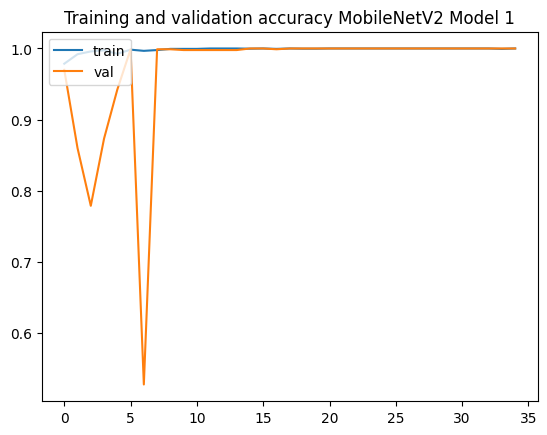

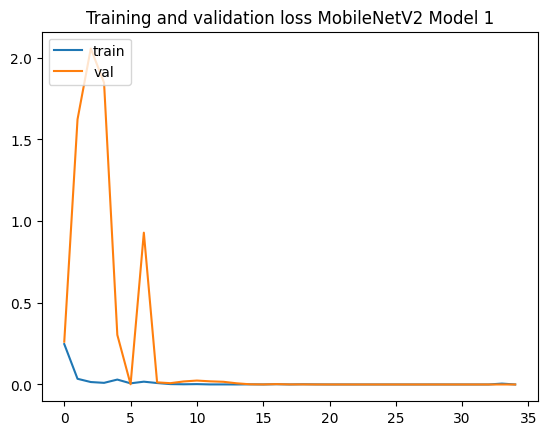

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_1.history['accuracy' ]
val_acc  = history_MobileNetV2_model_1.history['val_accuracy' ]
loss     = history_MobileNetV2_model_1.history['loss' ]
val_loss = history_MobileNetV2_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 1')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
!zip -r /content/Strawberry_MobileNetV2_model1_Based_Augmented.zip /content/Strawberry_MobileNetV2_model1_Based_Augmented

  adding: content/Strawberry_MobileNetV2_model1_Based_Augmented/ (stored 0%)
  adding: content/Strawberry_MobileNetV2_model1_Based_Augmented/variables/ (stored 0%)
  adding: content/Strawberry_MobileNetV2_model1_Based_Augmented/variables/variables.index (deflated 77%)
  adding: content/Strawberry_MobileNetV2_model1_Based_Augmented/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: content/Strawberry_MobileNetV2_model1_Based_Augmented/assets/ (stored 0%)
  adding: content/Strawberry_MobileNetV2_model1_Based_Augmented/keras_metadata.pb (deflated 96%)
  adding: content/Strawberry_MobileNetV2_model1_Based_Augmented/fingerprint.pb (stored 0%)
  adding: content/Strawberry_MobileNetV2_model1_Based_Augmented/saved_model.pb (deflated 91%)


mobilenetv2_2

In [19]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Strawberry_MobileNetV2_model2_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [20]:
# Define DIY Model
MobileNetV2_model_2 = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                                 
Total params: 2,586,434
Trainable params: 2,552,322
No

In [21]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_2 = MobileNetV2_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
180/180 [==============================] - ETA: 0s - loss: 0.0556 - accuracy: 0.9814
Epoch 1: val_accuracy improved from -inf to 0.79889, saving model to Strawberry_MobileNetV2_model2_Based_Augmented


180/180 [==============================] - 122s 443ms/step - loss: 0.0556 - accuracy: 0.9814 - val_loss: 3.5391 - val_accuracy: 0.7989 - lr: 0.0010
Epoch 2/100
180/180 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 0.9861
Epoch 2: val_accuracy improved from 0.79889 to 0.97000, saving model to Strawberry_MobileNetV2_model2_Based_Augmented


180/180 [==============================] - 77s 430ms/step - loss: 0.0506 - accuracy: 0.9861 - val_loss: 0.4195 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 3/100
180/180 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.9992
Epoch 3: val_accuracy improved from 0.97000 to 0.99667, saving model to Strawberry_MobileNetV2_model2_Based_Augmented


180/180 [==============================] - 77s 426ms/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.0650 - val_accuracy: 0.9967 - lr: 0.0010
Epoch 4/100
180/180 [==============================] - ETA: 0s - loss: 4.7101e-04 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 0.99667
180/180 [==============================] - 53s 292ms/step - loss: 4.7101e-04 - accuracy: 1.0000 - val_loss: 0.2412 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 5/100
180/180 [==============================] - ETA: 0s - loss: 2.2412e-04 - accuracy: 1.0000
Epoch 5: val_accuracy did not improve from 0.99667
180/180 [==============================] - 52s 288ms/step - loss: 2.2412e-04 - accuracy: 1.0000 - val_loss: 1.6637 - val_accuracy: 0.9111 - lr: 0.0010
Epoch 6/100
180/180 [==============================] - ETA: 0s - loss: 0.0405 - accuracy: 0.9911
Epoch 6: val_accuracy did not improve from 0.99667
180/180 [==============================] - 55s 303ms/step - loss: 0.0405 - accuracy: 0.9911 - val_l

180/180 [==============================] - 79s 438ms/step - loss: 0.0016 - accuracy: 0.9992 - val_loss: 0.0054 - val_accuracy: 0.9989 - lr: 1.0000e-05
Epoch 18/100
180/180 [==============================] - ETA: 0s - loss: 3.0940e-04 - accuracy: 1.0000
Epoch 18: val_accuracy did not improve from 0.99889
180/180 [==============================] - 52s 290ms/step - loss: 3.0940e-04 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 0.9989 - lr: 1.0000e-05
Epoch 19/100
180/180 [==============================] - ETA: 0s - loss: 9.8391e-04 - accuracy: 0.9997
Epoch 19: val_accuracy did not improve from 0.99889
180/180 [==============================] - 53s 293ms/step - loss: 9.8391e-04 - accuracy: 0.9997 - val_loss: 0.0016 - val_accuracy: 0.9989 - lr: 1.0000e-05
Epoch 20/100
180/180 [==============================] - ETA: 0s - loss: 4.4024e-04 - accuracy: 1.0000
Epoch 20: val_accuracy did not improve from 0.99889
180/180 [==============================] - 52s 290ms/step - loss: 4.4024e-04 

180/180 [==============================] - 78s 435ms/step - loss: 9.7042e-04 - accuracy: 0.9997 - val_loss: 5.9113e-04 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 22/100
180/180 [==============================] - ETA: 0s - loss: 5.9834e-04 - accuracy: 0.9997
Epoch 22: val_accuracy did not improve from 1.00000
180/180 [==============================] - 53s 293ms/step - loss: 5.9834e-04 - accuracy: 0.9997 - val_loss: 3.6607e-04 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 23/100
180/180 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 0.9989
Epoch 23: val_accuracy did not improve from 1.00000
180/180 [==============================] - 52s 287ms/step - loss: 0.0028 - accuracy: 0.9989 - val_loss: 3.1497e-04 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 24/100
180/180 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9994
Epoch 24: val_accuracy did not improve from 1.00000
180/180 [==============================] - 52s 288ms/step - loss: 0.0014 

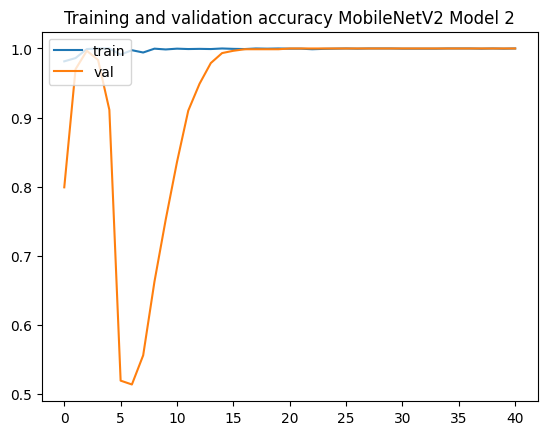

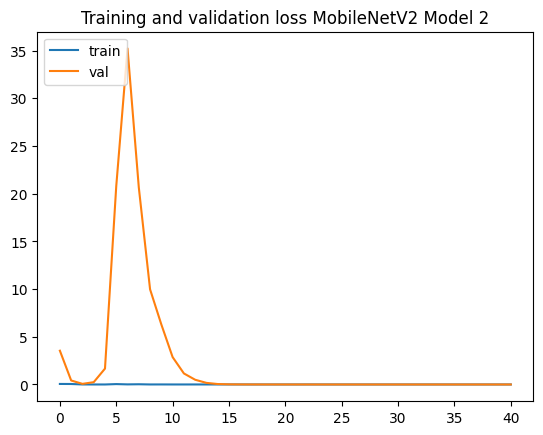

In [22]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_2.history['accuracy' ]
val_acc  = history_MobileNetV2_model_2.history['val_accuracy' ]
loss     = history_MobileNetV2_model_2.history['loss' ]
val_loss = history_MobileNetV2_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')

In [23]:
!zip -r /content/Strawberry_MobileNetV2_model2_Based_Augmented.zip /content/Strawberry_MobileNetV2_model2_Based_Augmented

  adding: content/Strawberry_MobileNetV2_model2_Based_Augmented/ (stored 0%)
  adding: content/Strawberry_MobileNetV2_model2_Based_Augmented/variables/ (stored 0%)
  adding: content/Strawberry_MobileNetV2_model2_Based_Augmented/variables/variables.index (deflated 76%)
  adding: content/Strawberry_MobileNetV2_model2_Based_Augmented/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: content/Strawberry_MobileNetV2_model2_Based_Augmented/assets/ (stored 0%)
  adding: content/Strawberry_MobileNetV2_model2_Based_Augmented/keras_metadata.pb (deflated 96%)
  adding: content/Strawberry_MobileNetV2_model2_Based_Augmented/fingerprint.pb (stored 0%)
  adding: content/Strawberry_MobileNetV2_model2_Based_Augmented/saved_model.pb (deflated 91%)
